La librería sindy tienen algún problema con numpy y python a mi me funcionaron las siguientes versiones:
!sudo apt-get update -y
!sudo apt-get install python3.10 -y
!pip install pysindy==1.7.3
!pip install numpy==1.21.6

!pip install scikit-learn==0.23

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:10 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:10 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:10 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InReleas

# Practica 8 - Reconstrucción
**1er Cuatrimestre 2025**

**DF - FCEyN - UBA**

En este Notebook aprenderemos a a encontrar las ecuaciones diferenciales de un sistema a partir de la serie temporal de sus variables.

## 0)  Repaso Teórico [Extra]

Para repasar el tema visto en la clase teórica, les dejamos esta pequeña introducción tomada de la documentación de `pysindy`.

El planteo del problema vale en forma general, mas allá que uno utilice como **sparse regression** el algoritmo propuesto por la librería `pysindy` o utilice algún otro de los algoritmos disponibles, como la regresión Lasso o la Ridge.

### 0.1) Main Idea

Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.



### 0.2) Approximation problem

To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

## 1) Preparación del Dataset

En esta priemr parte, vamos a trabajar con datos generados a partir de un sistema de Lorenz.

### 1.1) Simulación: Atractor de Lorenz

Simulamos el sistema utilizando el método de Runge-Kutta.

In [ ]:
# Imports de utilidades de Python



In [ ]:
# Definición de las funciones a utilizar

def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6


def ecuaciones(X,t, sig = 10.0, b = 8.0/3.0, ro = 28.0):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''

    x,y,z = X

    x_dot = sig * ( y - x )
    y_dot = x * (ro - z) - y
    z_dot = x * y - b * z

    return [x_dot, y_dot, z_dot]


def integrar_ecuaciones(total_time,dt,X0):

    '''
    Recibe:
       total_time: Tiempo total del integración
       dt: Paso temporal (h del método)
       X0: Lista con [x0,y0] valores iniciales de la integración
       params: Lista con los parámetros del sistema
    Devuelve:
       x_s, y_s: Vectores con las soluciones para ambas variables
       num_steps: Numero de pasos de integracion
    '''

    num_steps = int(np.divide(total_time,dt))

    # Empty vectors
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    zs = np.empty(num_steps)

    # Set initial values
    xs[0], ys[0], zs[0] = X0

    t = 0.0

    # Integramos con método de Euler
    for i in range(num_steps-1):
        xs[i + 1], ys[i + 1], zs[i + 1] = rk4(ecuaciones,[xs[i], ys[i], zs[i]],t,dt)
        t += dt

    return xs, ys, zs, num_steps

Ahora si, definimos los parametros de la intergación, integramos y ploteamos las soluciones.

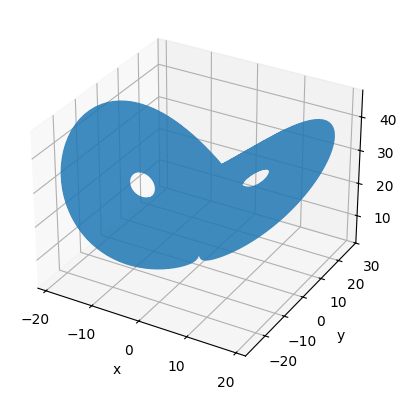

In [ ]:
# Parámetros de integración



# Simulamos los datos




# Ploteamos las soluciones
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 1.2) Calculo de derivadas y diccionario de funciones

Para realizar la regresión Lasso precisamos no solo contar con la serie temporal de las varables, sino también con su derivada temporal. Para calcularla vamos a usar la función `gradient()` de numpy. Pueden encontrar el algoritmo númerico que utiliza para calcularlas [en su documentación](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html).

In [ ]:
# Computamos la derivadas
# Noten que es preciso multiplicar normalizar por el paso temporal


# Lo unimos en una única matriz con el shape adecuado


(800000, 3)


Ademas de las derivadas, también precisamos acomodar en la matriz `theta` los términos polinomicos que vamos a utilizar.

In [ ]:
# Definimos la matriz vacia


# Completamos con los términos correspondientes


# Para luego comparar con los resultados obtenidos, definimos estas listas


**Observación:** Realizamos el calculo de los atributos polinómicos de manera manual para transparentar el proceso. Pero existen soluciones de librerias, como `PolynomialFeatures` de `sklearn`, que lo realizan de manera automática (cosa que puede resultar muy comoda, en especial para ordenes mas altos).

## 2) Reconstrucción de las ecuaciones con Lasso

In [ ]:
from IPython.display import Image
Image(url='https://media.tenor.com/images/783541733d62d72c20790d1f5d9ca70d/tenor.gif')

Sabemos que el sistema de ecuaciones que buscamos usualmente cuenta con una cantidad limitad de terminos no nulos. Para evitar un `overfitting` donde se activen muchos términos en las ecuaciones, utilizamos técnicas de regularización en la regresión.

Una de las técnicas de regularización mas utilizadas es la de sumar el módulo del valor de los coeficientes del modelo a la función de costo. Esto se conoce como regularización **Lasso** o **$L_1$** (por la norma).


### 2.1) Primer Lasso

La librería Scikit-Learn cuenta varias implementaciones de este tipo de regresiónes lineales con regularización. Primero vamos a utilizar la regresión Lasso clásica, [aquí su documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).


In [ ]:
from sklearn import linear_model

# Definimos el modelo


Noten que, al definir la matriz theta, agregamos una columna de unos como primer columna. De esta forma el primer coeficiente de cada ecuación corresponde al término independiente de la misma. Es por esto que debemos setear `fit_intercept=False` al definir el modelo.

In [ ]:
# Realizamos el ajuste


Lasso(alpha=0.2, fit_intercept=False, max_iter=100000)

Inspeccionemos el valor numerico de los resultados:

Coeficientes en x:
[ 0.00000000e+00 -8.87030797e+00  9.28615143e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -3.12960184e-02  0.00000000e+00
  1.96495147e-02  3.06058597e-05]


Coeficientes en y:
[-0.00000000e+00  2.68060827e+01 -2.63843652e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -9.66648907e-01 -0.00000000e+00
 -2.03132436e-02 -3.16053502e-05]


Coeficientes en z:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.58498016e+00
  3.18330941e-02  9.70887193e-01 -8.41499011e-06  5.69162139e-03
  0.00000000e+00 -3.97917167e-03]


Para comparar los resultados obtenidos con los coeficientes originales, vamos a graficarlos.

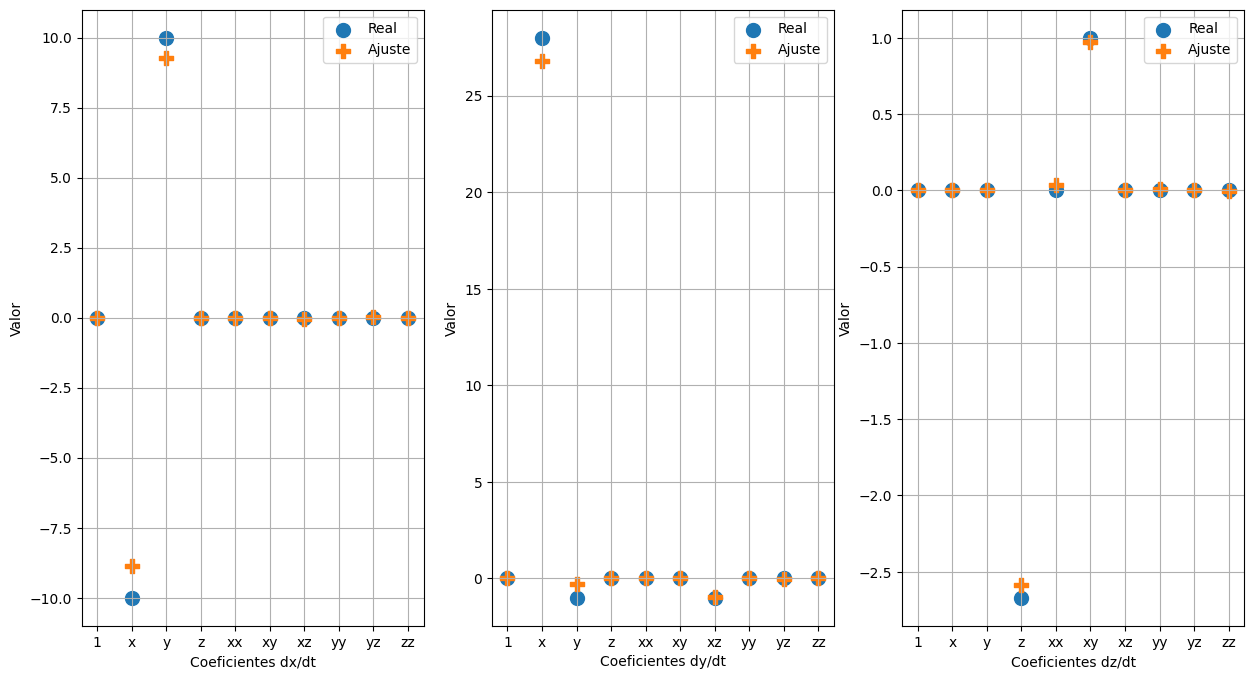

**Discutir:**

*   ¿Sobrevivieron únicamente los terminos originales?
*   Observando el valor de los coeficientes en los términos que se corresponden con los de las ecuaciones originales, ¿Nota alguna particularidad?

### 2.2) Lasso - Variando Alpha

Una pregunta interesante para hacerse es: **¿Cómo elegir el hiperparámetro alpha?**

No hay un valor óptimo universal para el hiperparametro alpha, depende del dataset con el que estemos trabajando. Recuerden que normalmente no vamos a tener las ecuaciones reales para contrastar (de hecho estas ecuaciones son precisamente lo que estamos buscando).

Una forma válida de elegir el hiperparámetro es definir el número máximo de terminos que pretendemos que aparezcan en nuestras ecuaciones. Pero, siendo que no conmocemos la cantidad mínima de terminos relevantes, esta desición resulta arbitraria.

Otra forma es entrenar el modelo para distintos valores de alpha y evaluar la performance del modelo sobre un set distinto al de entrenamiento (test set). Esperamos que el modelo encontrado con el valor mas adecuado de alpha generalice mejor a los datos de test.



In [ ]:
# Generamos un vector con los valores de alpha a explorar


[1.00000000e-04 1.83298071e-04 3.35981829e-04 6.15848211e-04
 1.12883789e-03 2.06913808e-03 3.79269019e-03 6.95192796e-03
 1.27427499e-02 2.33572147e-02 4.28133240e-02 7.84759970e-02
 1.43844989e-01 2.63665090e-01 4.83293024e-01 8.85866790e-01
 1.62377674e+00 2.97635144e+00 5.45559478e+00 1.00000000e+01]


Separamos los datos en un set de entrenamieto y uno de prueba.

In [ ]:
# Proporcion entre train y test


# Indice de separacion entre train y test

# Separamos la matriz Theta en 2 partes, una para el train set y otra para el test set.


# Hacemos lo mismo con las derivadas


**Atención:** Por una cuestión de simplicidad y velocidad, vamos a realizar el análisis solo para la ecaución correspondiente a la varaible $x$. Pero el mismo analisis puede aplicarse a todo el sistema completo.

Para cada valor de alhpa, entrenamos un modelo sobre el traing set y lo evaluamos en el test set (en terminos del `mean_squared_error` y del `mean_absolute_error`).

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Preparamos las listas donde vamos a guardar los datos


# Recorremos los distintos valores de alpha


    # Guadamos los coeficientes encontrados


    # Computamos el error cometido con 2 métricas distintas


    # Guardamos el error


Calculando con alpha =  0.0001
Calculando con alpha =  0.00018329807108324357
Calculando con alpha =  0.0003359818286283781
Calculando con alpha =  0.0006158482110660267
Calculando con alpha =  0.0011288378916846883
Calculando con alpha =  0.00206913808111479
Calculando con alpha =  0.00379269019073225
Calculando con alpha =  0.0069519279617756054
Calculando con alpha =  0.012742749857031334
Calculando con alpha =  0.023357214690901212
Calculando con alpha =  0.04281332398719392
Calculando con alpha =  0.07847599703514607
Calculando con alpha =  0.14384498882876628
Calculando con alpha =  0.26366508987303583
Calculando con alpha =  0.4832930238571752
Calculando con alpha =  0.8858667904100823
Calculando con alpha =  1.623776739188721
Calculando con alpha =  2.9763514416313193
Calculando con alpha =  5.455594781168514
Calculando con alpha =  10.0


Grafiquemos el error en función del parámetro alpha.  

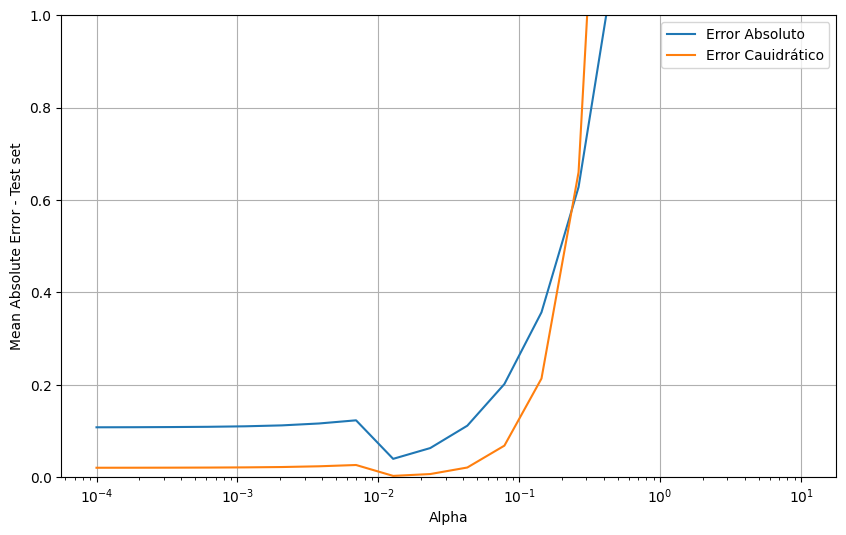

In [ ]:
plt.figure(figsize=(10,6))

plt.show()

**Ejercicio:** ¿Qué valor de alpha eligirían? Recuerden que, por lo general, un parametro alpha mas grande corresponde a un modelo mas simple, con menos terminos no nulos.

Por último vamos a graficar cómo varían los coeficientes a medida que variamos el valor de regularización.

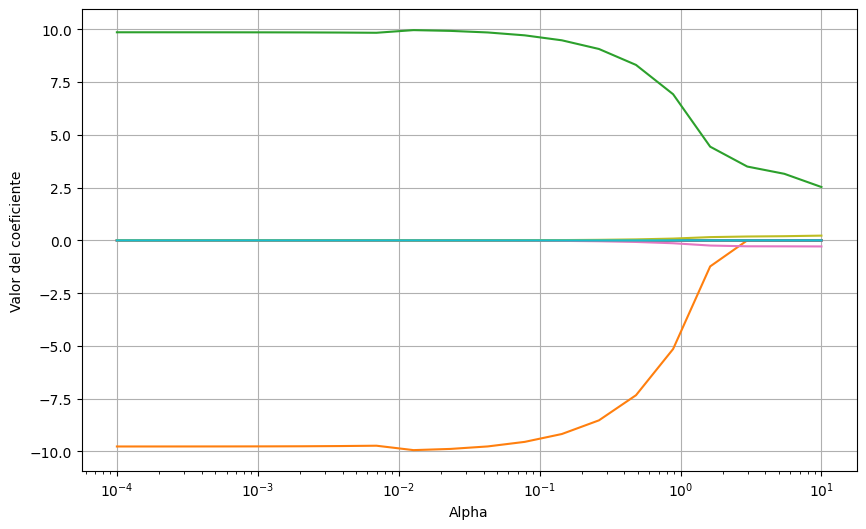

In [ ]:
plt.figure(figsize=(10,6))

plt.show()

**Ejercicio:** Repita el proceso realizado, pero esta vez para la ecuación correspondiente a la variable $z$.

**Observaciones:**
*  En este caso, donde contamos con una gran cantidad de datos simulados, este tipo de analisis resulta válido. Pero, si la cantidad de datos disponibles para realizar la regresión fuese menor o mas ruidosa, sería necesario realizar un proceso de cros-validación para encontrar el hiperparámetro adecuado.

*  Una vez que encontaron cuales son los terminos que sobreviven en el valor de alpha óptimo, una buena estrategia podría ser volver a realizar una regresión, pero esta vez utilizando únicamente estos términos y reduciendo (o directamente anulando) el peso de la regularización (alpha). Este proceso normalmente mejora el valor de los coeficientes obtenidos. Parte de esta idea es lo que motiva al método de la próxima sección.


**Ejercicio:** Pruebe cambiar el modelo a `sklearn.linear_model.Ridge` , que utiliza regularización tipo Ridege ($L_2$) en lugar de Lasso. Observe para este caso como se reducen los coeficientes en funcion de parametro de penalización.


## 3) Reconstrucción de las ecuaciones con Sindy

Sindy es una librería de python dedicada a la identificación de sistemas dinamicos a partir de datos. La librería contiene varias utilizades dedicadas a este fin, entre ellas podemos destacar:
*   Distintos tipos de *sparse regressions*.
*   Funciones para computar features extras.
*   Funciones para computar derivadas de señales.

La característica mas importante de la librería es un tipo de regresión llamada **Sequentially thresholded least squares** ([Aqui su código](https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/stlsq.html)). Este algotritmo es muy parecido al proceso que realizamos en la sección anterior pero con la diferencia que usa una regularización tipo Ridge (los coeficientes entran en la función de costo elevados al cuadrado) y que el algoritmo va *apagando* automáticamente los términos inferiores a cierto *treshold*.


### 3.1) *Structure of PySINDy* - de la documentación

The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

$$ \dot X \approx \Theta(X)\Xi. $$

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.

### 3.2) Implmentación

La principal ventaja de utilizar esta librería es la simplicidad con la que se puede implementar la regresión. Noten que, a diferencia de lo que hicimos en la sección anterior, la librería calcula las derivadas y los términos polinómicos automáticamente.

In [ ]:
import pysindy as ps

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23

In [ ]:
# Hiperparámetros


# Definición del modelo

    # Elegimos el optimizador a utilizar

    # Elegimos los features (términos de las escuaciones) a utilizar

    # Le ponemos un nombre a las variables



# Adecuamos nuestros datos en la matriz 'data'


# En la primer dimensión van los pasos temporales y en la segunda las varables


(800000, 3)


Finalmente entrenamos el modelo:

In [ ]:
# Entrenamiento




(x)' = -9.994 x + 9.994 y
(y)' = 27.950 x + -0.990 y + -0.999 x z
(z)' = -2.665 z + 0.999 x y


Noten que los terminos con los que sobrevivieron en las ecuaciones son los correctos y, además, los valores numéricos de los coeficientes encontrados son increiblermente cercanos al los del sistema original!

Por último, podemos usar la misma libreria para integrar el modelo encontrado y comparar las soluciones con las del sistema original.

In [ ]:
# Definimos el vector de Tiempos

# Integramos el sistema encontrado durante ese timepo


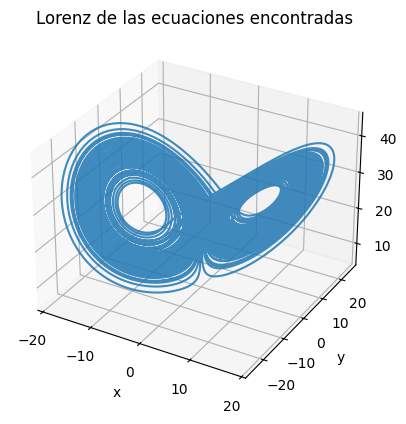

In [ ]:
# Graficamos las soluciones
fig = plt.figure()

plt.show()

## 4) Big Trouble in Little Van Der Pol
Siendo que funcionaron tan bien en un atractor caótico, a esta altura resulta muy tentador pensar que esta calse de métodos funcionaran bien en caulquier tipo de sistemas.

Definamos un nuevo dataset a partir del siguiente sistema de ecuaciones:


In [ ]:
def van_der_pol(X,t, mu = 7.0):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''

    x,y = X

    x_dot = y
    y_dot = mu * (1 - x * x) * y - x

    return [x_dot, y_dot]

Integramos usando odeint:

In [ ]:
from scipy.integrate import odeint



Grafiquemos como lucen las soluciones:

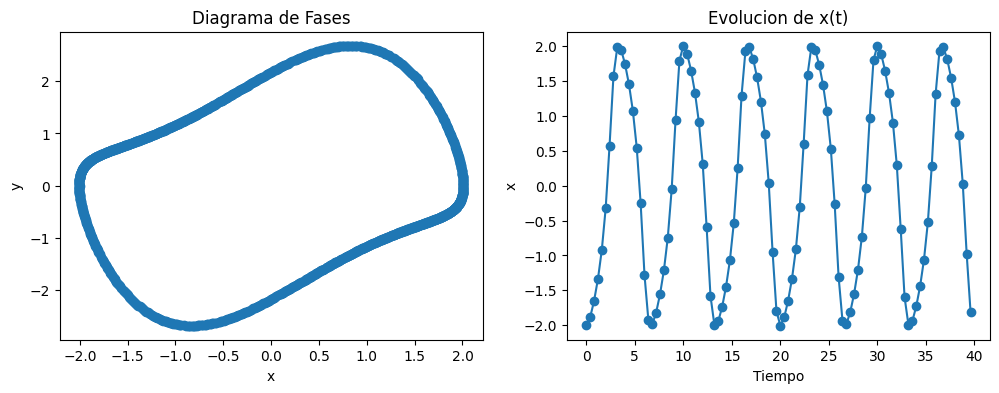

In [ ]:
plt.figure(figsize=(12,4))

plt.show()

Este es un oscilador de relajación muy popular llamado oscilador de **Van Der Pol**, cuyas ecuaciones son:

$$
	\begin{bmatrix} \frac{dx}{dt} \\ \frac{dy}{dt} \end{bmatrix}
	= \begin{bmatrix} y \\ -x + \mu y - \mu x^2y  \end{bmatrix}
$$


La dinámica en este caso no es muy compleja: un único termino cúbico y 3 terminos lineales dan lugar a una solución de tipo ciclo limite.

Además, contamos con mas de 35 samples por cada oscilación y ni siquiera estamos agregando ruido. Si pensamos en un escenario experimental, este sería un caso practicamente ideal.

**Ejercicio:**

*   Pruebe variar los hiperparametros *treshold* y *alpha* y explore los sistemas encontrados para este simple sistema dinamico.

*   ¿Coinciden los terminos encontrado con los del sistema original? ¿Son cualitativamente similares las soluciones?

*   ¿Cuál les parece que puede ser la causa de este desempeño?

*   Cambie el valor del parámetro $\mu$ en la función `val_der_pol()` de $\mu = 7$ a $\mu = 1$ y vuelva a realizar el ejercicio. ¿Mejora o emperoa la capacidad de reproducir las ecuaciones del sistema? ¿Qué cambió?

In [ ]:


# Hiperparámetros


# Definición del modelo

    # Specify the differentiation method here



# En la primer dimensión van los pasos temporales y en la segunda las varables


(800000, 3)


In [ ]:
# Entrenamiento


(x)' = 0.059 x + 1.009 y + -0.059 x y^2
(y)' = -0.797 x + 2.369 y + -0.082 x^3 + -1.235 x^2 y + 0.441 x y^2 + -0.349 y^3


Si graficamos las soluciones del sistema encontrado contra las del sistema original:

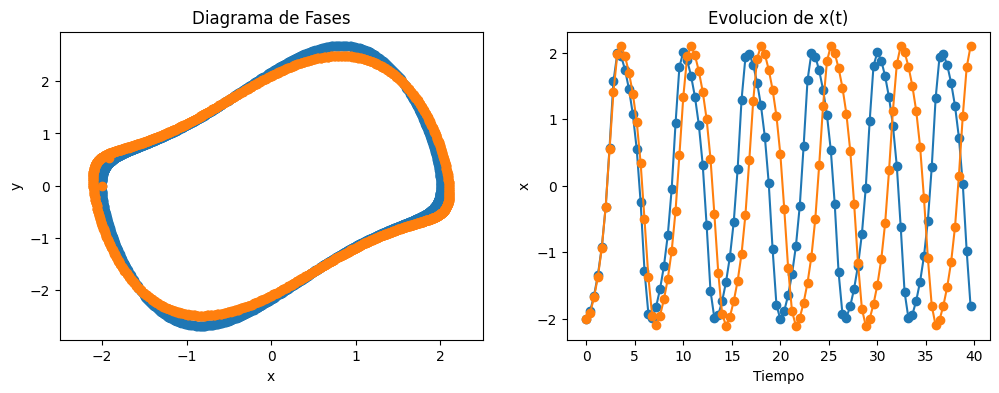